# Electric Vehicles

In this example, a battery electric vehicle (BEV) is driven 100 km in the morning and 100 km in the evening, to simulate commuting, and charged during the day by a solar panel at the driver's place of work. The size of the panel is computed by the optimisation.

The BEV has a battery of size 100 kWh and an electricity consumption of 0.18 kWh/km.

This example will use units of kW and kWh, unlike the PyPSA defaults. This is unproblematic as long as no power flow simulations are performed.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

import pypsa

As time index, we use a 24 hour period.

In [10]:
index = pd.date_range("2016-01-01 00:00", "2016-01-01 23:00", freq="h")

The consumption pattern in kW of the BEV is defined as follows

In [11]:
bev_usage = pd.Series([0] * 7 + [9] * 2 + [0] * 8 + [9] * 2 + [0] * 5, index)

The capacity factor profile of the solar panel in per-unit of capacity is given by:

In [12]:
pv_pu = pd.Series(
    [0.0] * 7
    + [0.2, 0.4, 0.6, 0.75, 0.85, 0.9, 0.85, 0.75, 0.6, 0.4, 0.2, 0.1]
    + [0.0] * 5,
    index,
)

The availability of charging - i.e. only when parked at office - is constrained as follows:

In [13]:
charger_p_max_pu = pd.Series(0, index=index)
charger_p_max_pu["2016-01-01 09:00":"2016-01-01 16:00"] = 1

Together, this gives:

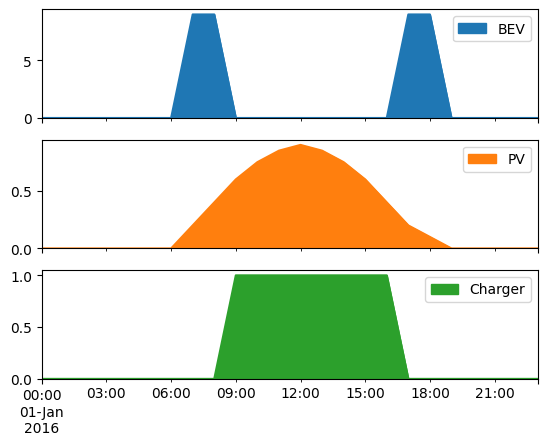

In [14]:
df = pd.concat({"BEV": bev_usage, "PV": pv_pu, "Charger": charger_p_max_pu}, axis=1)
df.plot.area(subplots=True);

Now initialise the network and add the relevant components. Then optimise:

In [18]:
n = pypsa.Network()
n.set_snapshots(index)

n.add("Bus", "place of work")

n.add("Bus", "car battery")

n.add(
    "Generator",
    "PV panel",
    bus="place of work",
    p_nom_extendable=True,
    p_max_pu=pv_pu,
    capital_cost=1000, # dummy cost value
)

n.add("Load", "driving", bus="car battery", p_set=bev_usage)

n.add(
    "Link",
    "charger",
    bus0="place of work",
    bus1="car battery",
    p_nom=120,
    p_max_pu=charger_p_max_pu,
    efficiency=0.9,
)

n.add("Store", "battery", bus="car battery", e_cyclic=True, e_nom=100);

In [19]:
n.optimize()
print("Objective:", n.objective)

Index(['charger'], dtype='object', name='Link')
Index(['battery'], dtype='object', name='Store')
Index(['place of work', 'car battery'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 97 primals, 217 duals
Objective: 7.02e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-g74el2af has 217 rows; 97 cols; 325 nonzeros
Coefficient ranges:
  Matrix [1e-01, 1e+00]
  Cost   [1e+03, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [9e+00, 1e+02]
Presolving model
16 rows, 17 cols, 40 nonzeros  0s
12 rows, 13 cols, 32 nonzeros  0s
10 rows, 11 cols, 28 nonzeros  0s
Dependent equations search running on 1 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
9 rows, 9 cols, 24 nonzeros  0s
Presolve : Reductions: rows 9(-208); columns 9(-88); elements 24(-301)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(36) 0s
          9     7.0175438596e+03 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-g74el2af
Model status        : Opti

The optimal panel size in kW is:

In [20]:
n.generators.p_nom_opt["PV panel"]

np.float64(7.0175438596491215)

<Axes: xlabel='snapshot'>

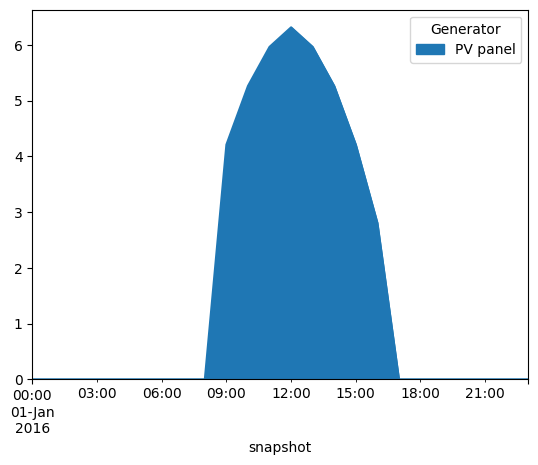

In [21]:
n.generators_t.p.plot.area()

The battery operation is optimised to follow:

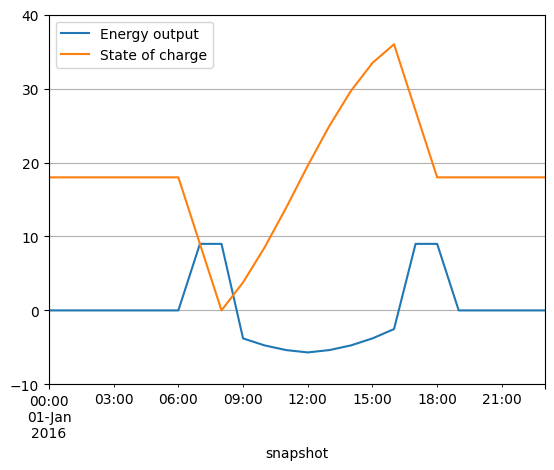

In [23]:
df = pd.DataFrame(
    {attr: n.stores_t[attr]["battery"] for attr in ["p", "e"]}
)
df.plot(grid=True, ylim=(-10, 40))
plt.legend(labels=["Energy output", "State of charge"])

The losses in kWh per pay are:

In [24]:
(
    n.generators_t.p.loc[:, "PV panel"].sum()
    - n.loads_t.p.loc[:, "driving"].sum()
)

np.float64(3.999999999999986)

<Axes: xlabel='snapshot'>

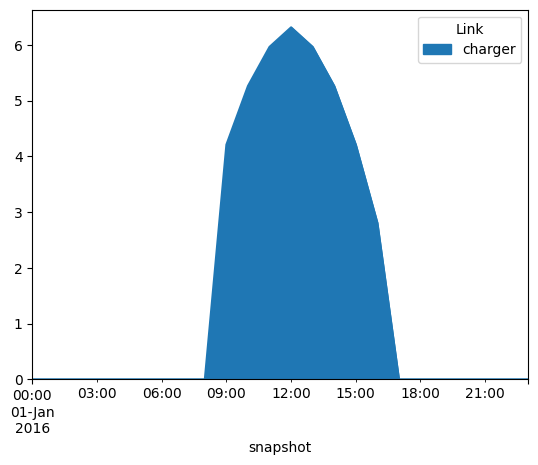

In [25]:
n.links_t.p0.plot.area()